## EE660_Project: Hardik Prajapati (2678294168)

In [1]:
import cv2
import numpy as np
import os 
from skimage import feature
from imutils import paths
from imutils import build_montages
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import math

In [2]:
def extract_feature(img):
    feat=feature.hog(img,orientations=9,pixels_per_cell=(10,10),cells_per_block=(2,2),transform_sqrt=True,block_norm='L1')
    return feat

In [3]:
def data_getter(root):
    #root="..\\data\\spiral\\training\\parkinson"
    file_path=os.listdir(root)
    data=[]
    label=[]
    label_val=root.split(os.path.sep)[-1]
    for path in file_path:
        img_path=os.path.join(root,path)
        image=cv2.imread(img_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        image=cv2.resize(image,(200,200))
        #image = cv2.threshold(image, 0, 255,cv2.THRESH_BINARY_INV)[1]
        feature1=extract_feature(image)
        data.append(feature1)
        label.append(label_val)
    return np.array(data), np.array(label)

In [4]:
def metric_clf(cm_model):
    (tn, fp, fn, tp)=cm_model.ravel()
    acc=(tn+tp)/float(tn+fp+fn+tp)
    sensitivity=(tp)/float(tp+fn)
    specificity=tn/float(tn+fp)
    
    return acc,sensitivity,specificity

In [5]:
#grab trainging data for spiral images
data_spiral1,label_spiral1=data_getter("..\\data\\spiral\\training\\healthy")
data_spiral2,label_spiral2=data_getter("..\\data\\spiral\\training\\parkinson")
trainX_spiral=np.concatenate((data_spiral1,data_spiral2), axis=0)
trainY_spiral=np.concatenate((label_spiral1,label_spiral2), axis=0)
print(len(trainY_spiral))
print(len(trainX_spiral))

72
72


In [6]:
#grab testing data for spiral images
data_spiral1,label_spiral1=data_getter("..\\data\\spiral\\testing\\healthy")
data_spiral2,label_spiral2=data_getter("..\\data\\spiral\\testing\\parkinson")
testX_spiral=np.concatenate((data_spiral1,data_spiral2), axis=0)
testY_spiral=np.concatenate((label_spiral1,label_spiral2), axis=0)
print(len(testY_spiral))
print(len(testX_spiral))

30
30


In [7]:
#grab training data for wave images
data_wave1,label_wave1=data_getter("..\\data\\wave\\training\\healthy")
data_wave2,label_wave2=data_getter("..\\data\\wave\\training\\parkinson")
trainX_wave=np.concatenate((data_wave1,data_wave2), axis=0)
trainY_wave=np.concatenate((label_wave1,label_wave2), axis=0)
print(len(trainY_wave))
print(len(trainX_wave))

72
72


In [8]:
#grab testing data for wave images
data_wave1,label_wave1=data_getter("..\\data\\wave\\testing\\healthy")
data_wave2,label_wave2=data_getter("..\\data\\wave\\testing\\parkinson")
testX_wave=np.concatenate((data_wave1,data_wave2), axis=0)
testY_wave=np.concatenate((label_wave1,label_wave2), axis=0)
print(len(testY_wave))
print(len(testX_wave))

30
30


In [9]:
# Change labels to 0:healthy, 1:Parkinson
le = LabelEncoder()
trainY_spiral = le.fit_transform(trainY_spiral)
testY_spiral = le.transform(testY_spiral)
trainY_wave = le.transform(trainY_wave)
testY_wave = le.transform(testY_wave)

In [10]:
def display_output(model_trained,target_type):
    if target_type=='spiral':
        testingPath = os.path.sep.join(["..\\data\\spiral\\", "testing"])
        testingPaths = list(paths.list_images(testingPath))
    elif target_type=='wave':
        testingPath = os.path.sep.join(["..\\data\\wave\\", "testing"])
        testingPaths = list(paths.list_images(testingPath))

    idxs = np.arange(0, len(testingPaths))
    idxs = np.random.choice(idxs, size=(25,), replace=False)
    images = []
    # loop over the testing samples
    for i in idxs:
        # load the testing image, clone it, and resize it
        image = cv2.imread(testingPaths[i])
        true_label=testingPaths[i].split(os.path.sep)[-2]
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        # pre-process the image in the same manner we did earlier
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        features = extract_feature(image)
        preds = model_trained.predict([features])
        label = le.inverse_transform(preds)[0]
        # draw the colored class label on the output image and add it to
        # the set of output images
        color = (0, 255, 0) if label == true_label else (0, 0, 255)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,color, 2)
        images.append(output)
    montage=build_montages(images,(128, 128), (5, 5))[0]
    cv2.imshow("Results",montage)
    cv2.waitKey(600)
    cv2.destroyAllWindows()
    
    return montage

In [11]:
def save_montage(montage_image,name):
    filename="..//output//"+name+".jpg"
    
    cv2.imwrite(filename,montage_image)

In [12]:
#Define a dictionary to store metric evaluation of models performed on Spiral test
Spiral_acc={"AllParkinson":0,"CART":0,"RandomForest":0,"Adaboost":0 }
Spiral_sen={"AllParkinson":0,"CART":0,"RandomForest":0,"Adaboost":0 }
Spiral_spe={"AllParkinson":0,"CART":0,"RandomForest":0,"Adaboost":0 }

In [13]:
#Trivial-Base Model
#implement a classifier which predicts Parkinson all time
predY_spiral=[1]*len(testX_spiral)
cm_spiral=confusion_matrix(testY_spiral, predY_spiral)
acc,sen,spec=metric_clf(cm_spiral)

#(tn, fp, fn, tp)=cm_spiral.ravel()
Spiral_acc["AllParkinson"]=acc
Spiral_sen["AllParkinson"]=sen
Spiral_spe["AllParkinson"]=spec

#print(a)
#Spiral_acc

In [14]:
#non-trivial base model
#train DecisionTree classifier on Spiral images and evaluate metric on test data of spiral images
a=[]
b=[]
c=[]
for i in range(5):
    model_spiral=DecisionTreeClassifier()
    model_spiral.fit(trainX_spiral,trainY_spiral)
    predY_spiral=model_spiral.predict(testX_spiral)
    cm_spiral=confusion_matrix(testY_spiral, predY_spiral)
    acc,sen,spec=metric_clf(cm_spiral)
    a.append(acc)
    b.append(sen)
    c.append(spec)

#(tn, fp, fn, tp)=cm_spiral.ravel()
Spiral_acc["CART"]=np.mean(a)
Spiral_sen["CART"]=np.mean(b)
Spiral_spe["CART"]=np.mean(c)
montage_cart=display_output(model_spiral,'spiral')
save_montage(montage_cart,"CART")

#print(a)
#Spiral_acc

In [15]:
#train RandomForest on Spiral images and evaluate metric on test data of spiral images
a=[]
b=[]
c=[]
for i in range(5):
    model_spiral=RandomForestClassifier(n_estimators=100)
    model_spiral.fit(trainX_spiral,trainY_spiral)
    predY_spiral=model_spiral.predict(testX_spiral)
    cm_spiral=confusion_matrix(testY_spiral, predY_spiral)
    acc,sen,spec=metric_clf(cm_spiral)
    a.append(acc)
    b.append(sen)
    c.append(spec)

#(tn, fp, fn, tp)=cm_spiral.ravel()
Spiral_acc["RandomForest"]=np.mean(a)
Spiral_sen["RandomForest"]=np.mean(b)
Spiral_spe["RandomForest"]=np.mean(c)
montage_rf=display_output(model_spiral,'spiral')
save_montage(montage_rf,"RF")

#print(a)
#Spiral_acc

In [16]:
#train AdaBoost classifier on Spiral images and evaluate metric on test data of spiral images
model_spiral=AdaBoostClassifier(n_estimators=100, learning_rate=0.001)
model_spiral.fit(trainX_spiral,trainY_spiral)
predY_spiral=model_spiral.predict(testX_spiral)
cm_spiral=confusion_matrix(testY_spiral, predY_spiral)
acc,sen,spec=metric_clf(cm_spiral)

#(tn, fp, fn, tp)=cm_spiral.ravel()
Spiral_acc["Adaboost"]=acc
Spiral_sen["Adaboost"]=sen
Spiral_spe["Adaboost"]=spec
montage_adaboost=display_output(model_spiral,'spiral')
save_montage(montage_adaboost,"Adaboost")

#Spiral_acc

In [17]:
#Define a dictionary to store metric evaluation of models performed on Wave test
Wave_acc={"AllParkinson":0,"CART":0,"RandomForest":0,"Adaboost":0 }
Wave_sen={"AllParkinson":0,"CART":0,"RandomForest":0,"Adaboost":0 }
Wave_spe={"AllParkinson":0,"CART":0,"RandomForest":0,"Adaboost":0 }

In [18]:
#Trivial-Base Model
#implement a classifier which predicts Parkinson all time
predY_wave=[1]*len(testX_wave)
cm_wave=confusion_matrix(testY_wave, predY_wave)
acc,sen,spec=metric_clf(cm_wave)

#(tn, fp, fn, tp)=cm_spiral.ravel()
Wave_acc["AllParkinson"]=acc
Wave_sen["AllParkinson"]=sen
Wave_spe["AllParkinson"]=spec


In [19]:
#train DecisionTree classifier on Wave images and evaluate metric on test data of Wave images
a=[]
b=[]
c=[]
for i in range(5):
    model_wave=DecisionTreeClassifier()
    model_wave.fit(trainX_wave,trainY_wave)
    predY_wave=model_wave.predict(testX_wave)
    cm_wave=confusion_matrix(testY_wave, predY_wave)
    acc,sen,spec=metric_clf(cm_wave)
    a.append(acc)
    b.append(sen)
    c.append(spec)

#(tn, fp, fn, tp)=cm_spiral.ravel()
Wave_acc["CART"]=np.mean(a)
Wave_sen["CART"]=np.mean(b)
Wave_spe["CART"]=np.mean(c)
montage_cart=display_output(model_wave,'wave')
save_montage(montage_cart,"CART_wave")
#print(a)
#Wave_acc

In [20]:
#train RandomForest on Wave images and evaluate metric on test data of wave images
a=[]
b=[]
c=[]
for i in range(5):
    model_wave=RandomForestClassifier(n_estimators=100)
    model_wave.fit(trainX_wave,trainY_wave)
    predY_wave=model_wave.predict(testX_wave)
    cm_wave=confusion_matrix(testY_wave, predY_wave)
    acc,sen,spec=metric_clf(cm_wave)
    a.append(acc)
    b.append(sen)
    c.append(spec)

#(tn, fp, fn, tp)=cm_spiral.ravel()
Wave_acc["RandomForest"]=np.mean(a)
Wave_sen["RandomForest"]=np.mean(b)
Wave_spe["RandomForest"]=np.mean(c)
montage_rf2=display_output(model_wave,'wave')
save_montage(montage_rf2,"RF_wave")
#print(a)
#Wave_acc

In [21]:
#train AdaBoost classifier on Wave images and evaluate metric on test data of Wave images
model_wave=AdaBoostClassifier(n_estimators=100, learning_rate=0.001)
model_wave.fit(trainX_wave,trainY_wave)
predY_wave=model_wave.predict(testX_wave)
cm_wave=confusion_matrix(testY_wave, predY_wave)
acc,sen,spec=metric_clf(cm_wave)

#(tn, fp, fn, tp)=cm_spiral.ravel()
Wave_acc["Adaboost"]=acc
Wave_sen["Adaboost"]=sen
Wave_spe["Adaboost"]=spec
montage_adaboost2=display_output(model_wave,'wave')
save_montage(montage_adaboost2,"Adaboost_wave")
#Wave_acc

Spiral Dataset: Accuracy {'AllParkinson': 0.5, 'CART': 0.6066666666666667, 'RandomForest': 0.8, 'Adaboost': 0.7666666666666667}
Wave Dataset: Accuracy {'AllParkinson': 0.5, 'CART': 0.6266666666666667, 'RandomForest': 0.6333333333333333, 'Adaboost': 0.5666666666666667}


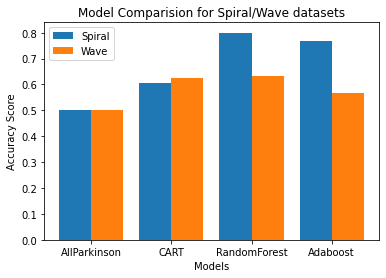

In [22]:
print("Spiral Dataset: Accuracy", Spiral_acc)
print("Wave Dataset: Accuracy", Wave_acc)
X=list(Wave_acc.keys())
X_axis=np.arange(len(X))
Y=[]
Z=[]
for j in Spiral_acc:
    Y.append(Spiral_acc[j])
for k in Wave_acc:
    Z.append(Wave_acc[k])

plt.bar(X_axis - 0.2, Y, 0.4, label = 'Spiral')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Wave')
  
plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Model Comparision for Spiral/Wave datasets")
plt.legend()
plt.show()

Spiral Dataset: Sensitivity {'AllParkinson': 1.0, 'CART': 0.48, 'RandomForest': 0.7466666666666667, 'Adaboost': 0.5333333333333333}
Wave Dataset: Sensitivity {'AllParkinson': 1.0, 'CART': 0.72, 'RandomForest': 0.6533333333333333, 'Adaboost': 0.7333333333333333}


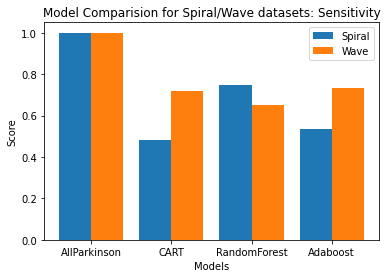

In [23]:
print("Spiral Dataset: Sensitivity", Spiral_sen)
print("Wave Dataset: Sensitivity", Wave_sen)
X=list(Wave_sen.keys())
X_axis=np.arange(len(X))
Y=[]
Z=[]
for j in Spiral_sen:
    Y.append(Spiral_sen[j])
for k in Wave_sen:
    Z.append(Wave_sen[k])

plt.bar(X_axis - 0.2, Y, 0.4, label = 'Spiral')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Wave')
  
plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Comparision for Spiral/Wave datasets: Sensitivity")
plt.legend()
plt.show()

Spiral Dataset: Specificity {'AllParkinson': 0.0, 'CART': 0.7333333333333333, 'RandomForest': 0.8533333333333333, 'Adaboost': 1.0}
Wave Dataset: Specificity {'AllParkinson': 0.0, 'CART': 0.5333333333333333, 'RandomForest': 0.6133333333333333, 'Adaboost': 0.4}


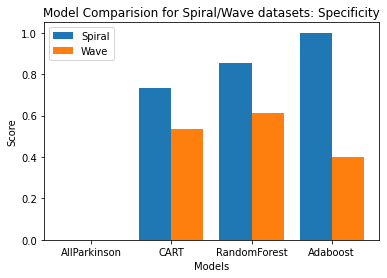

In [24]:
print("Spiral Dataset: Specificity", Spiral_spe)
print("Wave Dataset: Specificity", Wave_spe)
X=list(Wave_spe.keys())
X_axis=np.arange(len(X))
Y=[]
Z=[]
for j in Spiral_spe:
    Y.append(Spiral_spe[j])
for k in Wave_spe:
    Z.append(Wave_spe[k])

plt.bar(X_axis - 0.2, Y, 0.4, label = 'Spiral')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Wave')
  
plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Comparision for Spiral/Wave datasets: Specificity")
plt.legend()
plt.show()

### Transfer Learning Approach: Importance Weighting 

In [25]:
#Source: Spiral images
#target: Wave images
data_spiral1,label_spiral1=data_getter("..\\data\\spiral\\training\\healthy")
data_spiral2,label_spiral2=data_getter("..\\data\\spiral\\testing\\healthy")
X_source_0=np.concatenate((data_spiral1,data_spiral2), axis=0)
Y_source_0=np.concatenate((label_spiral1,label_spiral2), axis=0)
data_spiral1,label_spiral1=data_getter("..\\data\\spiral\\training\\parkinson")
data_spiral2,label_spiral2=data_getter("..\\data\\spiral\\testing\\parkinson")
X_source_1=np.concatenate((data_spiral1,data_spiral2), axis=0)
Y_source_1=np.concatenate((label_spiral1,label_spiral2), axis=0)

Xtrain_target_0,Ytrain_target_0=data_getter("..\\data\\wave\\training\\healthy")
Xtrain_target_1,Ytrain_target_1=data_getter("..\\data\\wave\\training\\parkinson")
Xtest_target_0,Ytest_target_0=data_getter("..\\data\\wave\\testing\\healthy")
Xtest_target_1,Ytest_target_1=data_getter("..\\data\\wave\\testing\\parkinson")

In [26]:
#Source0+target0+source1+target1-arrangement of training data
X_class0=np.concatenate((X_source_0,Xtrain_target_0),axis=0)
X_class1=np.concatenate((X_source_1,Xtrain_target_1),axis=0)
Y_class0=np.concatenate((Y_source_0,Ytrain_target_0),axis=0)
Y_class1=np.concatenate((Y_source_1,Ytrain_target_1),axis=0)

Xtrain_final=np.concatenate((X_class0,X_class1),axis=0)
Ytrain_final=np.concatenate((Y_class0,Y_class1),axis=0)
Xtest_final=np.concatenate((Xtest_target_0,Xtest_target_1),axis=0)
Ytest_final=np.concatenate((Ytest_target_0,Ytest_target_1),axis=0)

#apply the same labelEncoder as in the case of Supervised learning
Ytrain_final = le.fit_transform(Ytrain_final)
Ytest_final = le.fit_transform(Ytest_final)

In [27]:
def class_conditional_density_KDE(Xsource,Xtrain_class,components):
    pca = PCA(n_components=components,whiten=False)
    data = pca.fit_transform(Xsource)
    Xtrain=pca.transform(Xtrain_class)

    # use grid search cross-validation to optimize the bandwidth
    params = {"bandwidth": np.logspace(-1, 1, 20)}
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), params)
    grid.fit(data)

    #print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

    # use the best estimator to compute the kernel density estimate
    kde = grid.best_estimator_
    log_density=kde.score_samples(Xtrain)
    weights=np.array(math.e**log_density)
    
    return weights

In [28]:
def class_conditional_density_GM(Xsource,Xtrain_class,components):
    pca = PCA(n_components=components,whiten=False)
    data = pca.fit_transform(Xsource)
    Xtrain=pca.transform(Xtrain_class)
    
    gm = GaussianMixture(n_components=1)
    gm=gm.fit(data)

    # use the best estimator to compute the kernel density estimate
    log_density=gm.score_samples(Xtrain)
    weights=np.array(math.e**log_density)

    return weights

In [29]:
n=1
w_source_0=class_conditional_density_GM(X_source_0,X_class0,n)
w_source_1=class_conditional_density_GM(X_source_1,X_class1,n)
W_source=np.concatenate((w_source_0,w_source_1),axis=0)
w_target_0=class_conditional_density_GM(Xtrain_target_0,X_class0,n)
w_target_1=class_conditional_density_GM(Xtrain_target_1,X_class1,n)
W_target=np.concatenate((w_target_0,w_target_1),axis=0)

#weights for samples
Weights_GM=np.divide(W_target, W_source)
#print("target_weights",W_target)
#print("source_weights",W_source)
Weights_GM

array([ 1.23072551,  1.67770426,  3.74649366,  1.15215181,  1.30544394,
        2.44319106,  3.38881927,  4.7028591 ,  1.29372613,  1.08533412,
        3.24318714,  1.07931979,  1.15572993,  3.96201634,  1.3842618 ,
        1.12507739,  1.10806882,  1.37693911,  1.77437423,  1.08160524,
        2.23522024,  1.15216628,  1.06058006,  2.04327563,  1.16951472,
        9.30074401,  1.76117315,  1.14291112,  1.10188505,  1.60980778,
        1.18169382, 13.73461963,  1.27269701,  1.25496258,  1.16982541,
        2.55612836,  2.07222975,  2.5076941 ,  3.14138925,  6.84141783,
        2.78306983,  1.73454968,  1.39098416,  1.11577353,  1.23654534,
        1.19769919,  1.46857207,  1.1437325 ,  1.0508604 ,  1.25293753,
        2.9880279 ,  0.1255086 ,  0.26905162,  1.70198212,  0.6373114 ,
        1.44754069,  1.36543537,  0.63996259,  0.88743702,  1.094875  ,
        1.38791428,  1.37150222,  0.68301936,  1.70530699,  1.34024914,
        0.6154735 ,  0.80890574,  1.57510392,  0.97253799,  0.36

In [30]:
n=1
w_source_0=class_conditional_density_KDE(X_source_0,X_class0,n)
w_source_1=class_conditional_density_KDE(X_source_1,X_class1,n)
W_source=np.concatenate((w_source_0,w_source_1),axis=0)
w_target_0=class_conditional_density_KDE(Xtrain_target_0,X_class0,n)
w_target_1=class_conditional_density_KDE(Xtrain_target_1,X_class1,n)
W_target=np.concatenate((w_target_0,w_target_1),axis=0)

#weights for samples
Weights_KDE=np.divide(W_target, W_source)
#print("target_weights",W_target)
#print("source_weights",W_source)
Weights_KDE

array([ 0.92723436,  1.61606743,  1.84718187,  0.83603398,  1.24184951,
        1.40610117,  2.33461122,  2.70115467,  0.88600051,  1.06997844,
        1.61594076,  0.80231054,  0.8419916 ,  2.01314769,  1.33107033,
        0.88408226,  1.12515122,  0.96030246,  1.6680879 ,  1.02755715,
        1.37150641,  0.84418473,  0.82898859,  1.35250319,  1.14631624,
        3.68292644,  1.65077543,  0.88557055,  1.10985468,  1.17570124,
        0.84483762,  4.93345584,  0.86969054,  0.8584615 ,  0.82713363,
        2.04859184,  1.8377783 ,  1.39988762,  1.57820218,  3.14401433,
        1.47035176,  1.25429947,  1.33175137,  1.07274082,  0.86478434,
        1.17366852,  1.08880472,  1.13542236,  0.97290138,  1.2077881 ,
        2.20304754,  0.2435571 ,  0.41967938,  1.24632991,  0.68227028,
        1.03087174,  1.11374451,  0.71750191,  0.86580604,  1.00465362,
        1.11660955,  1.10488547,  0.77547052,  1.26340125,  1.11257822,
        0.72549014,  0.80228513,  1.20920872,  0.92230702,  0.52

In [31]:
def plot_metric(acc,sen,spe):

    figure, axis = plt.subplots(3)
    figure.set_size_inches(19, 21)

    #print("\nTarget Dataset: Accuracy", acc)
    X=list(acc.keys())
    Y=[]
    for j in acc:
        Y.append(acc[j])
    pps1=axis[0].bar(X, Y, 0.4,color='b')
    for p in pps1:
        height= p.get_height()
        axis[0].annotate('{:.2f}'.format(height),
        xy=(p.get_x() + p.get_width() / 2, height),
        xytext=(0, 1), # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom')    
    axis[0].set(ylabel='score')
    axis[0].set_title("Model Comparision_TL: Accuracy")
    
    #print("\nTarget Dataset: Sensitivity", sen)
    X=list(sen.keys())
    Y=[]
    for j in sen:
        Y.append(sen[j])
    pps2=axis[1].bar(X, Y, 0.4, color='g')
    for p in pps2:
        height= p.get_height()
        axis[1].annotate('{:.2f}'.format(height),
        xy=(p.get_x() + p.get_width() / 2, height),
        xytext=(0, 1), # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom')    
    axis[1].set(ylabel='score')
    axis[1].set_title("Model Comparision_TL: Sensitivity")

    #print("\nTarget Dataset: Specificity", spe)
    X=list(spe.keys())
    Y=[]
    for j in spe:
        Y.append(spe[j])
    pps3=axis[2].bar(X, Y, 0.4, color='b')
    for p in pps3:
        height= p.get_height()
        axis[2].annotate('{:.2f}'.format(height),
        xy=(p.get_x() + p.get_width() / 2, height),
        xytext=(0, 1), # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom')    
    axis[2].set(xlabel='Models', ylabel='score')
    axis[2].set_title("Model Comparision_TL: Specificity")
    
    plt.show()

Case: Base models-Type1 for Transfer Learning | train: src, test: target


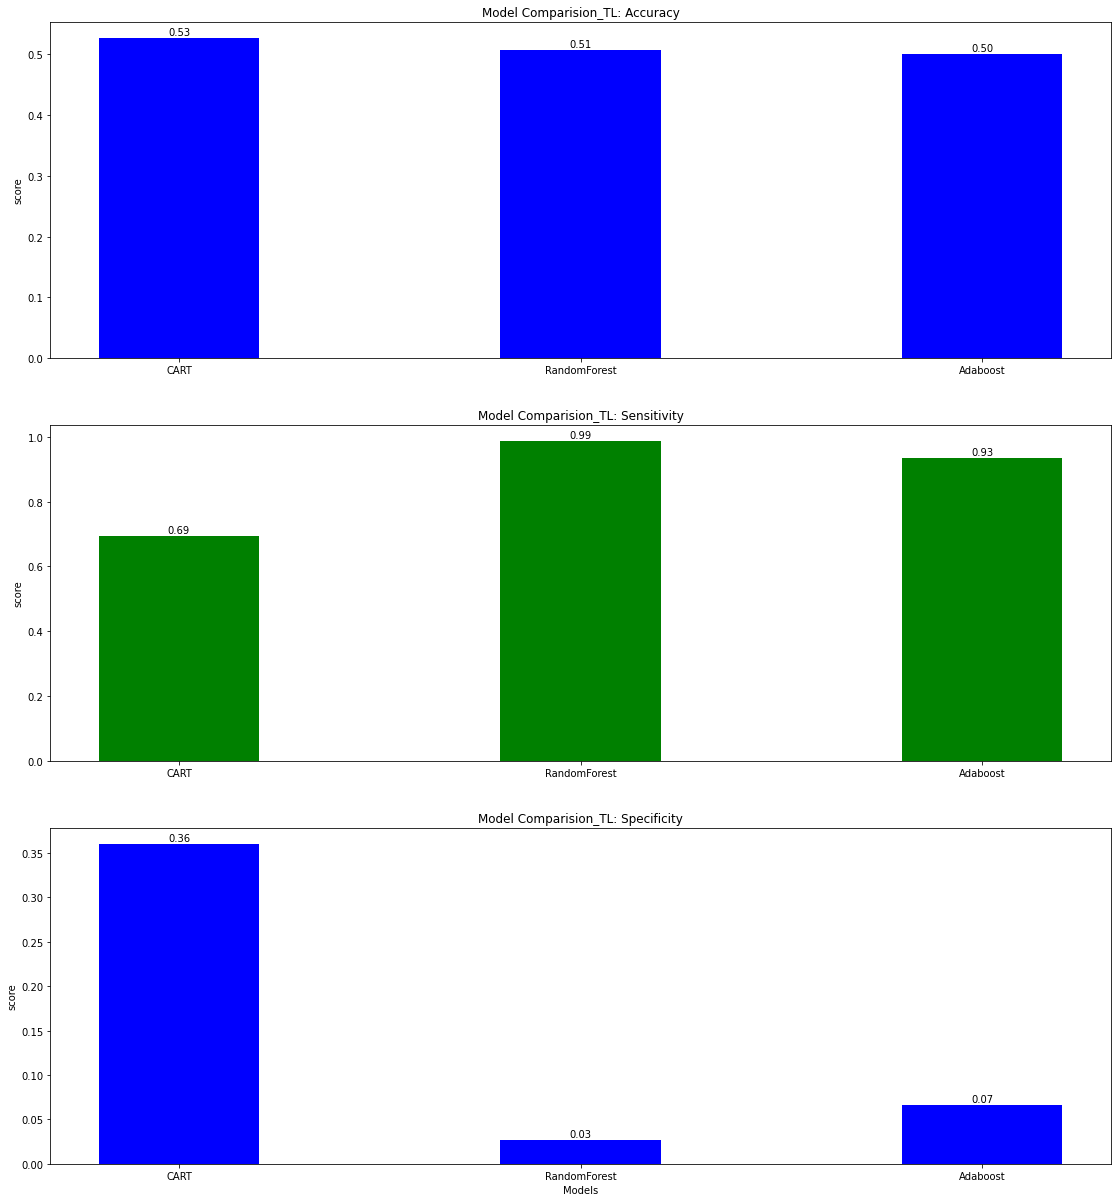

In [32]:
#base model: SL technique to use source and target train data for training the model
#and test on target testing data
#Define a dictionary to store metric evaluation of models performed on Spiral test
TLBase_acc={"CART":0,"RandomForest":0,"Adaboost":0 }
TLBase_sen={"CART":0,"RandomForest":0,"Adaboost":0 }
TLBase_spe={"CART":0,"RandomForest":0,"Adaboost":0 }

#train DecisionTree classifier on Spiral images and evaluate metric on test data of wave images
a=[]
b=[]
c=[]
for i in range(5):
    model_spiral=DecisionTreeClassifier()
    model_spiral.fit(trainX_spiral,trainY_spiral)
    predY_wave=model_spiral.predict(testX_wave)
    tlbase_cm=confusion_matrix(testY_wave, predY_wave)
    acc,sen,spec=metric_clf(tlbase_cm)
    a.append(acc)
    b.append(sen)
    c.append(spec)

#(tn, fp, fn, tp)=cm_spiral.ravel()
TLBase_acc["CART"]=np.mean(a)
TLBase_sen["CART"]=np.mean(b)
TLBase_spe["CART"]=np.mean(c)
montage_cart=display_output(model_spiral,'wave')
save_montage(montage_cart,"TLBase_CART")

#train RandomForest on Spiral images and evaluate metric on test data of wave images
a=[]
b=[]
c=[]
for i in range(5):
    model_spiral=RandomForestClassifier(n_estimators=100)
    model_spiral.fit(trainX_spiral,trainY_spiral)
    predY_wave=model_spiral.predict(testX_wave)
    tlbase_cm=confusion_matrix(testY_wave, predY_wave)
    acc,sen,spec=metric_clf(tlbase_cm)
    a.append(acc)
    b.append(sen)
    c.append(spec)

#(tn, fp, fn, tp)=cm_spiral.ravel()
TLBase_acc["RandomForest"]=np.mean(a)
TLBase_sen["RandomForest"]=np.mean(b)
TLBase_spe["RandomForest"]=np.mean(c)
montage_rf=display_output(model_spiral,'wave')
save_montage(montage_rf,"TLBase_RF")

#train AdaBoost classifier on spiral images and evaluate metric on test data of Wave images
model_wave=AdaBoostClassifier(n_estimators=100, learning_rate=0.001)
model_wave.fit(trainX_spiral,trainY_spiral)
predY_wave=model_wave.predict(testX_wave)
tlbase_cm=confusion_matrix(testY_wave, predY_wave)
acc,sen,spec=metric_clf(tlbase_cm)

#(tn, fp, fn, tp)=cm_spiral.ravel()
TLBase_acc["Adaboost"]=acc
TLBase_sen["Adaboost"]=sen
TLBase_spe["Adaboost"]=spec
montage_adaboost2=display_output(model_wave,'wave')
save_montage(montage_adaboost2,"TLBase_Adaboost")

print("Case: Base models-Type1 for Transfer Learning | train: src, test: target")
plot_metric(TLBase_acc,TLBase_sen,TLBase_spe)


In [33]:
def experiment_TL(sample_weights,density_type):
    #Define a dictionary to store metric evaluation of models performed on Target(Wave) domain test set
    target_acc={"CART":0,"RandomForest":0,"Adaboost":0 }
    target_sen={"CART":0,"RandomForest":0,"Adaboost":0 }
    target_spe={"CART":0,"RandomForest":0,"Adaboost":0 }
    
    #train CART on Source(train+test) + Target(train) data with importance weighting and evaluate metric on test data of Target(wave) images
    a=[]
    b=[]
    c=[]
    for i in range(5):
        model2_tl=DecisionTreeClassifier()
        model2_tl=model2_tl.fit(Xtrain_final,Ytrain_final,sample_weight=sample_weights)
        predY_model2=model2_tl.predict(Xtest_final)
        cm_model2=confusion_matrix(Ytest_final, predY_model2)
        acc,sen,spec=metric_clf(cm_model2)
        a.append(acc)
        b.append(sen)
        c.append(spec)

    #(tn, fp, fn, tp)=cm_spiral.ravel()
    target_acc["CART"]=np.mean(a)
    target_sen["CART"]=np.mean(b)
    target_spe["CART"]=np.mean(c)
    montage_cart_tl=display_output(model2_tl,'wave')
    save_montage(montage_cart_tl,"CART_TL_wave_"+density_type)
    
    #train RandomForest on Source(train+test) + Target(train) data with importance weighting and evaluate metric on test data of Target(wave) images
    a=[]
    b=[]
    c=[]
    for i in range(5):
        model3_tl=RandomForestClassifier(n_estimators=100)
        model3_tl=model3_tl.fit(Xtrain_final,Ytrain_final,sample_weight=sample_weights)
        predY_model3=model3_tl.predict(Xtest_final)
        cm_model3=confusion_matrix(Ytest_final, predY_model3)
        acc,sen,spec=metric_clf(cm_model3)
        a.append(acc)
        b.append(sen)
        c.append(spec)

    #(tn, fp, fn, tp)=cm_spiral.ravel()
    target_acc["RandomForest"]=np.mean(a)
    target_sen["RandomForest"]=np.mean(b)
    target_spe["RandomForest"]=np.mean(c)
    montage_rf_tl=display_output(model3_tl,'wave')
    save_montage(montage_rf_tl,"RF_TL_wave"+density_type)

    #train Adaboost on Source(train+test) + Target(train) data with importance weighting and evaluate metric on test data of Target(wave) images
    model4_tl=AdaBoostClassifier(n_estimators=100, learning_rate=0.001)
    model4_tl=model4_tl.fit(Xtrain_final,Ytrain_final,sample_weight=sample_weights)
    predY_model4=model4_tl.predict(Xtest_final)
    cm_model4=confusion_matrix(Ytest_final, predY_model4)
    acc,sen,spec=metric_clf(cm_model4)
    target_acc["Adaboost"]=acc
    target_sen["Adaboost"]=sen
    target_spe["Adaboost"]=spec
    montage_adaboost_tl=display_output(model4_tl,'wave')
    save_montage(montage_adaboost_tl,"Adaboost_TL_wave"+density_type)

    plot_metric(target_acc,target_sen,target_spe)
    

Case: Base models-Type2 for Transfer Learning | train: src+tgt, test: target


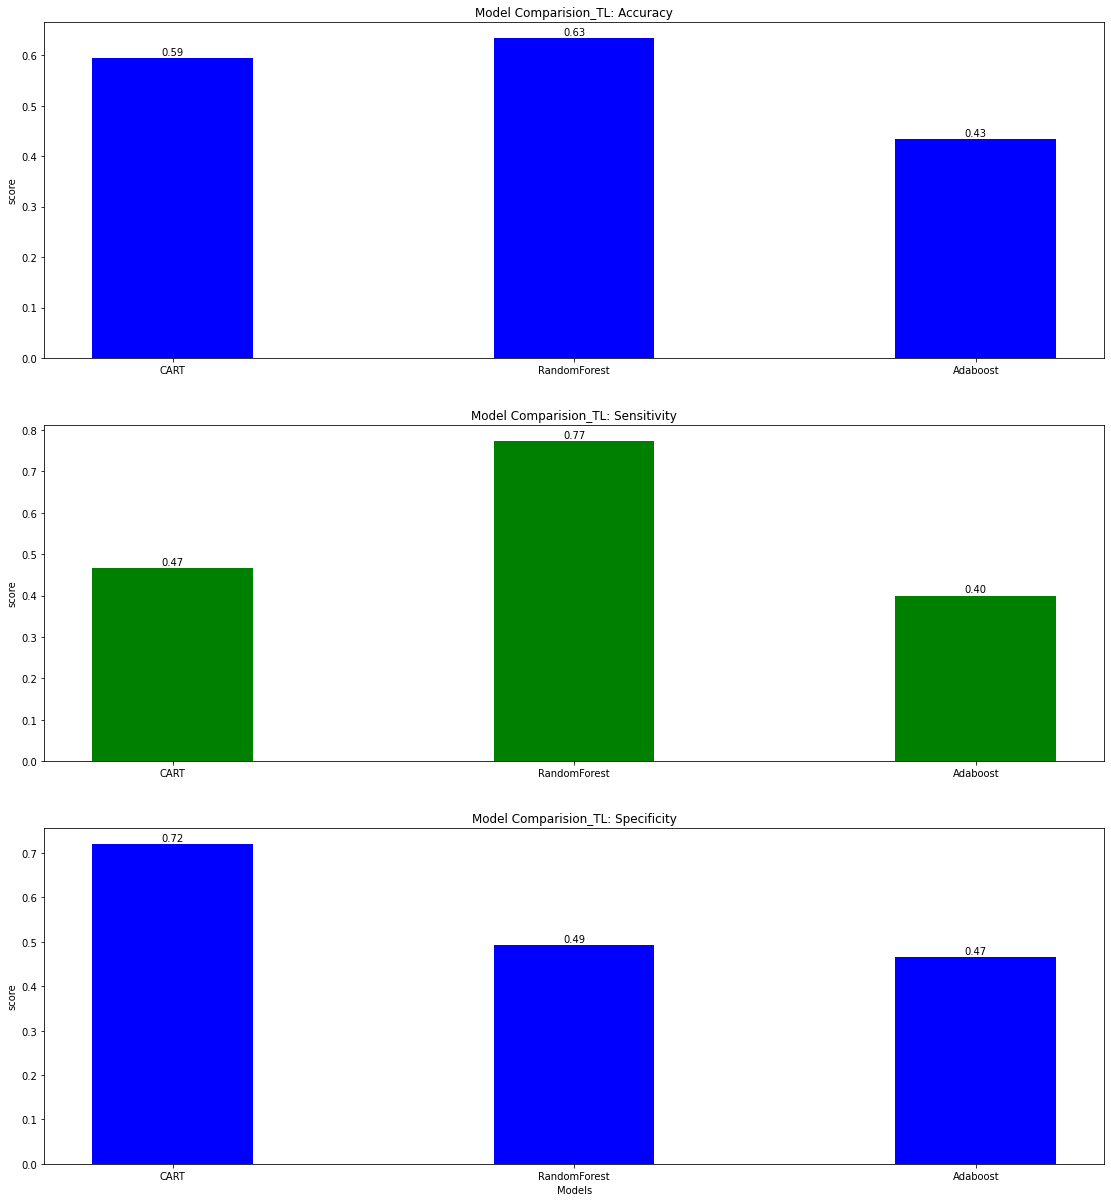

In [34]:
#Conduct experiment with weights=None, for compute Base Model-Type 2. Trained on union of 
#Source train+ source test+ target train and tested on target testing data
print("Case: Base models-Type2 for Transfer Learning | train: src+tgt, test: target")
experiment_TL(None,"Base2")

Case: Gaussian Mixture Density Estimation


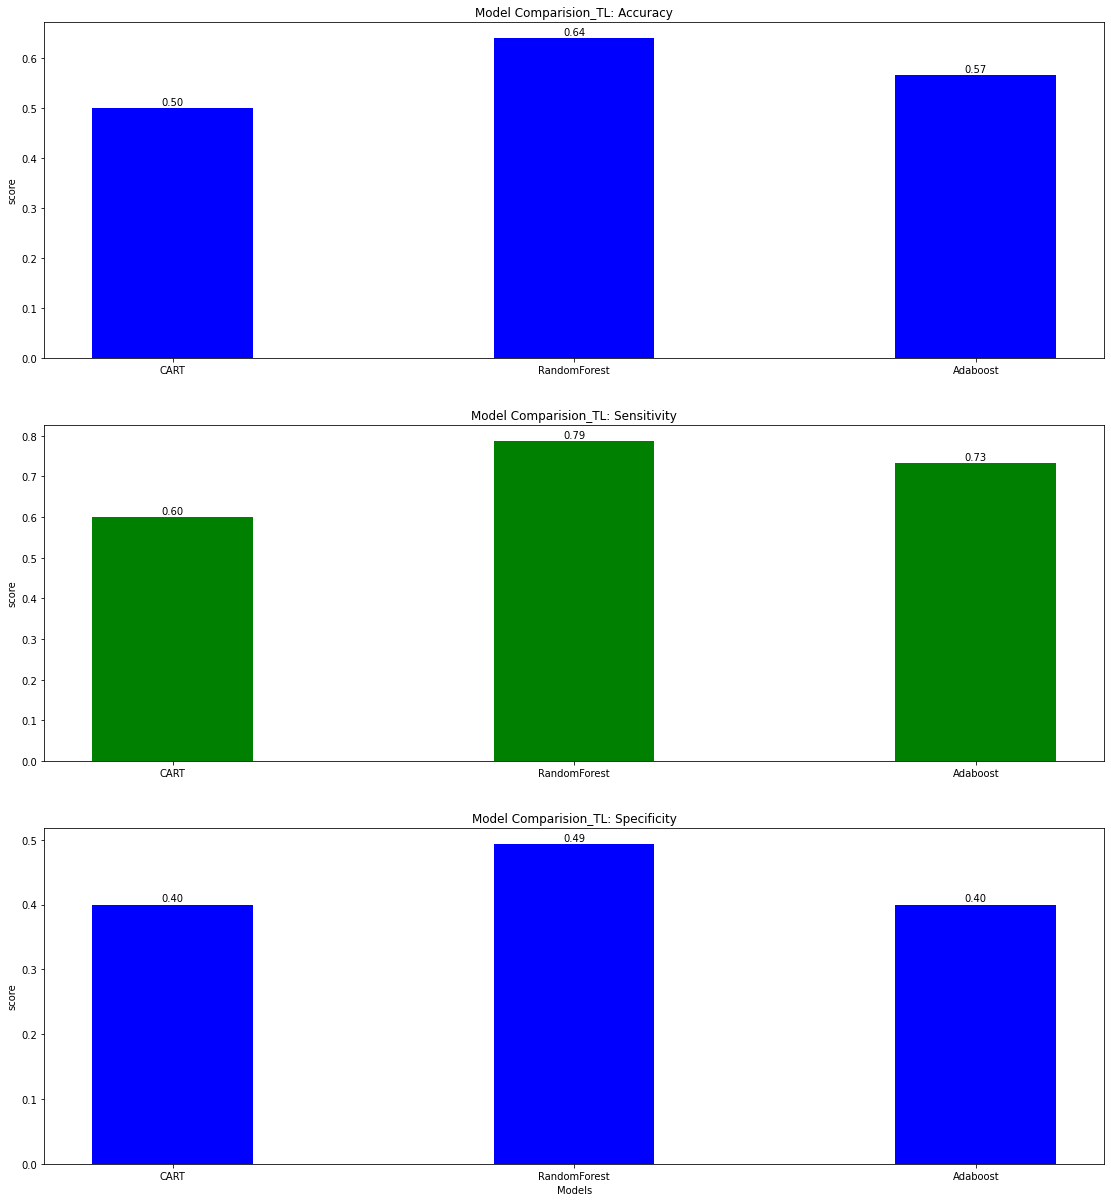

In [35]:
#conduct experiment with weights drawn from Gaussian Mixture Density Estimation
print("Case: Gaussian Mixture Density Estimation")
experiment_TL(Weights_GM,"GM")


case:KDE(kernel=Gaussian)


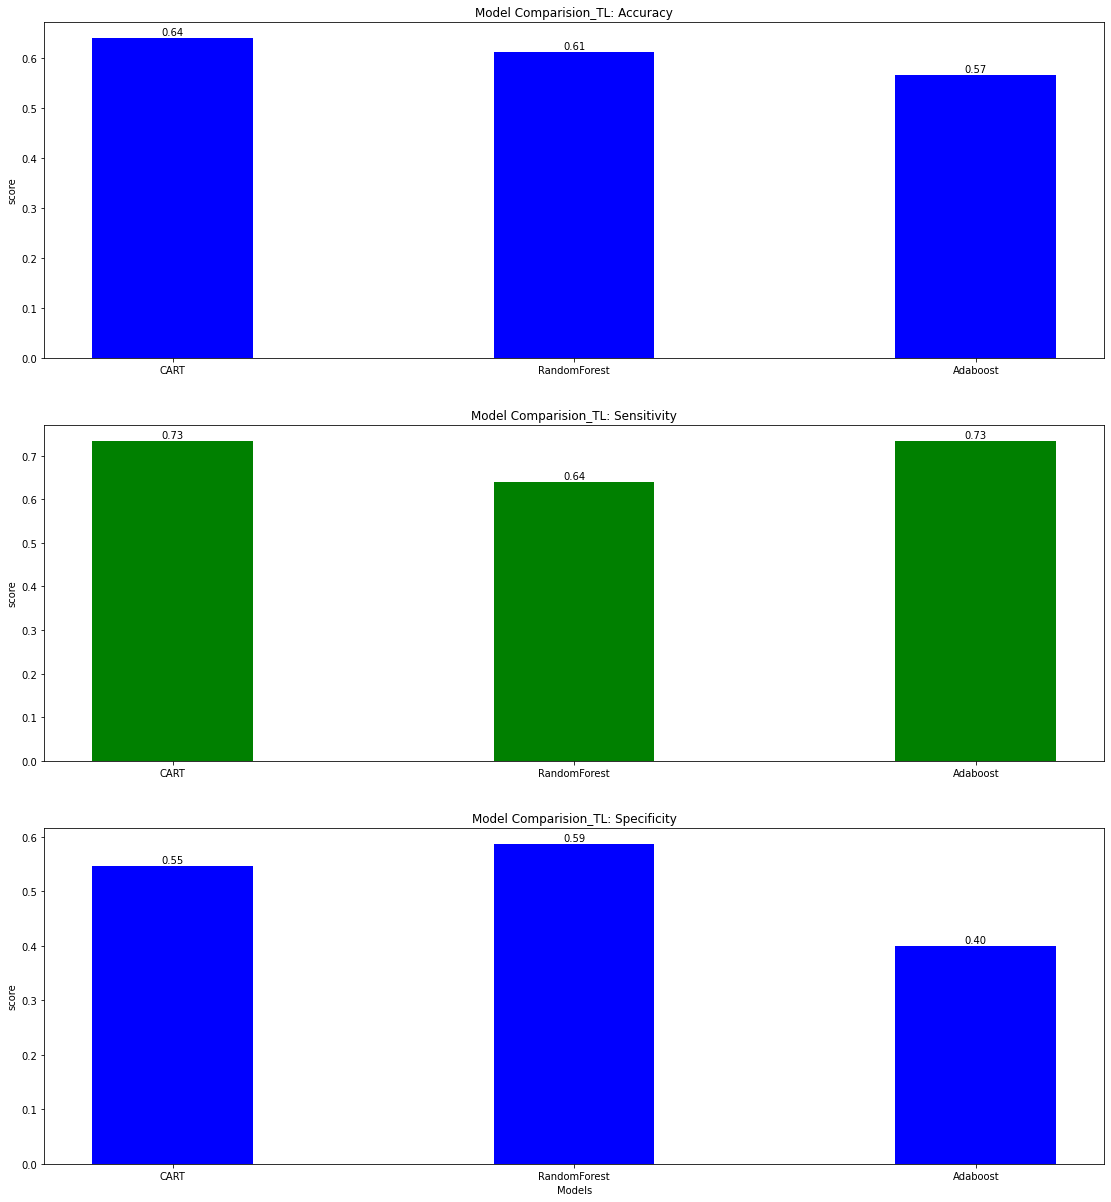

In [36]:
#conduct experiment with weights drawn from Kernel Density Estimation with Gaussian kernel
print("case:KDE(kernel=Gaussian)")
experiment_TL(Weights_KDE,"KDE")


## CHANGING SOURCE AND TARGET DOMAIN

In [37]:
#Source: Wave images
#target: Spiral images
data_wave1,label_wave1=data_getter("..\\data\\wave\\training\\healthy")
data_wave2,label_wave2=data_getter("..\\data\\wave\\testing\\healthy")
X_source_0=np.concatenate((data_wave1,data_wave2), axis=0)
Y_source_0=np.concatenate((label_wave1,label_wave2), axis=0)
data_wave1,label_wave1=data_getter("..\\data\\wave\\training\\parkinson")
data_wave2,label_wave2=data_getter("..\\data\\wave\\testing\\parkinson")
X_source_1=np.concatenate((data_wave1,data_wave2), axis=0)
Y_source_1=np.concatenate((label_wave1,label_wave2), axis=0)

Xtrain_target_0,Ytrain_target_0=data_getter("..\\data\\spiral\\training\\healthy")
Xtrain_target_1,Ytrain_target_1=data_getter("..\\data\\spiral\\training\\parkinson")
Xtest_target_0,Ytest_target_0=data_getter("..\\data\\spiral\\testing\\healthy")
Xtest_target_1,Ytest_target_1=data_getter("..\\data\\spiral\\testing\\parkinson")


In [38]:
#Source0+target0+source1+target1-arrangement of training data
X_class0=np.concatenate((X_source_0,Xtrain_target_0),axis=0)
X_class1=np.concatenate((X_source_1,Xtrain_target_1),axis=0)
Y_class0=np.concatenate((Y_source_0,Ytrain_target_0),axis=0)
Y_class1=np.concatenate((Y_source_1,Ytrain_target_1),axis=0)

Xtrain_final=np.concatenate((X_class0,X_class1),axis=0)
Ytrain_final=np.concatenate((Y_class0,Y_class1),axis=0)
Xtest_final=np.concatenate((Xtest_target_0,Xtest_target_1),axis=0)
Ytest_final=np.concatenate((Ytest_target_0,Ytest_target_1),axis=0)

#apply the same labelEncoder as in the case of Supervised learning
Ytrain_final = le.fit_transform(Ytrain_final)
Ytest_final = le.fit_transform(Ytest_final)

In [39]:
n=1
w_source_0=class_conditional_density_GM(X_source_0,X_class0,n)
w_source_1=class_conditional_density_GM(X_source_1,X_class1,n)
W_source=np.concatenate((w_source_0,w_source_1),axis=0)
w_target_0=class_conditional_density_GM(Xtrain_target_0,X_class0,n)
w_target_1=class_conditional_density_GM(Xtrain_target_1,X_class1,n)
W_target=np.concatenate((w_target_0,w_target_1),axis=0)

#weights for samples
Weights_GM_2=np.divide(W_target, W_source)
#print("target_weights",W_target)
#print("source_weights",W_source)
#Weights_GM_2

In [40]:
n=15
w_source_0=class_conditional_density_KDE(X_source_0,X_class0,n)
w_source_1=class_conditional_density_KDE(X_source_1,X_class1,n)
W_source=np.concatenate((w_source_0,w_source_1),axis=0)
w_target_0=class_conditional_density_KDE(Xtrain_target_0,X_class0,n)
w_target_1=class_conditional_density_KDE(Xtrain_target_1,X_class1,n)
W_target=np.concatenate((w_target_0,w_target_1),axis=0)

#weights for samples
Weights_KDE_2=np.divide(W_target, W_source)
#print("target_weights",W_target)
#print("source_weights",W_source)
#Weights_KDE_2

In [41]:
def experiment2_TL(sample_weights,density_type):
    #Define a dictionary to store metric evaluation of models performed on Target(Spiral) domain test set
    target_acc={"CART":0,"RandomForest":0,"Adaboost":0 }
    target_sen={"CART":0,"RandomForest":0,"Adaboost":0 }
    target_spe={"CART":0,"RandomForest":0,"Adaboost":0 }
    
    #train CART on Source(train+test) + Target(train) data with importance weighting and evaluate metric on test data of Target(wave) images
    a=[]
    b=[]
    c=[]
    for i in range(5):
        model2_tl=DecisionTreeClassifier()
        model2_tl=model2_tl.fit(Xtrain_final,Ytrain_final,sample_weight=sample_weights)
        predY_model2=model2_tl.predict(Xtest_final)
        cm_model2=confusion_matrix(Ytest_final, predY_model2)
        acc,sen,spec=metric_clf(cm_model2)
        a.append(acc)
        b.append(sen)
        c.append(spec)

    #(tn, fp, fn, tp)=cm_spiral.ravel()
    target_acc["CART"]=np.mean(a)
    target_sen["CART"]=np.mean(b)
    target_spe["CART"]=np.mean(c)
    montage_cart_tl=display_output(model2_tl,'spiral')
    save_montage(montage_cart_tl,"CART_TL_spiral_"+density_type)
    
    #train RandomForest on Source(train+test) + Target(train) data with importance weighting and evaluate metric on test data of Target(wave) images
    a=[]
    b=[]
    c=[]
    for i in range(5):
        model3_tl=RandomForestClassifier(n_estimators=100)
        model3_tl=model3_tl.fit(Xtrain_final,Ytrain_final,sample_weight=sample_weights)
        predY_model3=model3_tl.predict(Xtest_final)
        cm_model3=confusion_matrix(Ytest_final, predY_model3)
        acc,sen,spec=metric_clf(cm_model3)
        a.append(acc)
        b.append(sen)
        c.append(spec)

    #(tn, fp, fn, tp)=cm_spiral.ravel()
    target_acc["RandomForest"]=np.mean(a)
    target_sen["RandomForest"]=np.mean(b)
    target_spe["RandomForest"]=np.mean(c)
    montage_rf_tl=display_output(model3_tl,'spiral')
    save_montage(montage_rf_tl,"RF_TL_spiral"+density_type)

    #train Adaboost on Source(train+test) + Target(train) data with importance weighting and evaluate metric on test data of Target(wave) images
    model4_tl=AdaBoostClassifier(n_estimators=100, learning_rate=0.001)
    model4_tl=model4_tl.fit(Xtrain_final,Ytrain_final,sample_weight=sample_weights)
    predY_model4=model4_tl.predict(Xtest_final)
    cm_model4=confusion_matrix(Ytest_final, predY_model4)
    acc,sen,spec=metric_clf(cm_model4)
    target_acc["Adaboost"]=acc
    target_sen["Adaboost"]=sen
    target_spe["Adaboost"]=spec
    montage_adaboost_tl=display_output(model4_tl,'spiral')
    save_montage(montage_adaboost_tl,"Adaboost_TL_spiral"+density_type)

    plot_metric(target_acc,target_sen,target_spe)
    

Case: Src-Wave|Tgt-Spiral, Gaussian Mixture Density Estimation


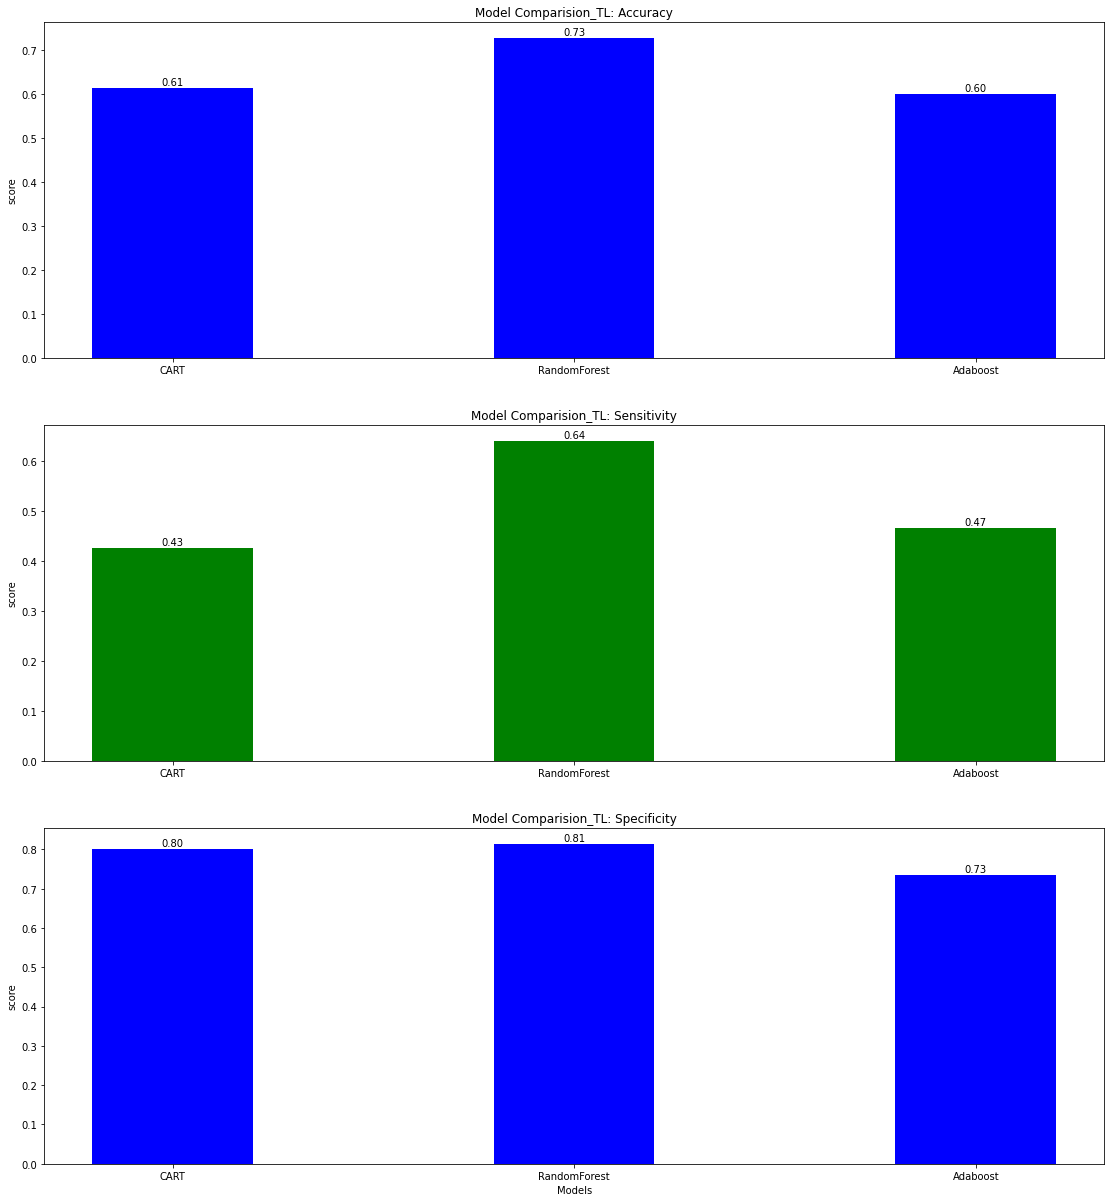

In [42]:
print("Case: Src-Wave|Tgt-Spiral, Gaussian Mixture Density Estimation")
experiment2_TL(Weights_GM_2,"GM")

Case: Src-Wave|Tgt-Spiral, Kernel Density Estimation(kernel=Gaussian)


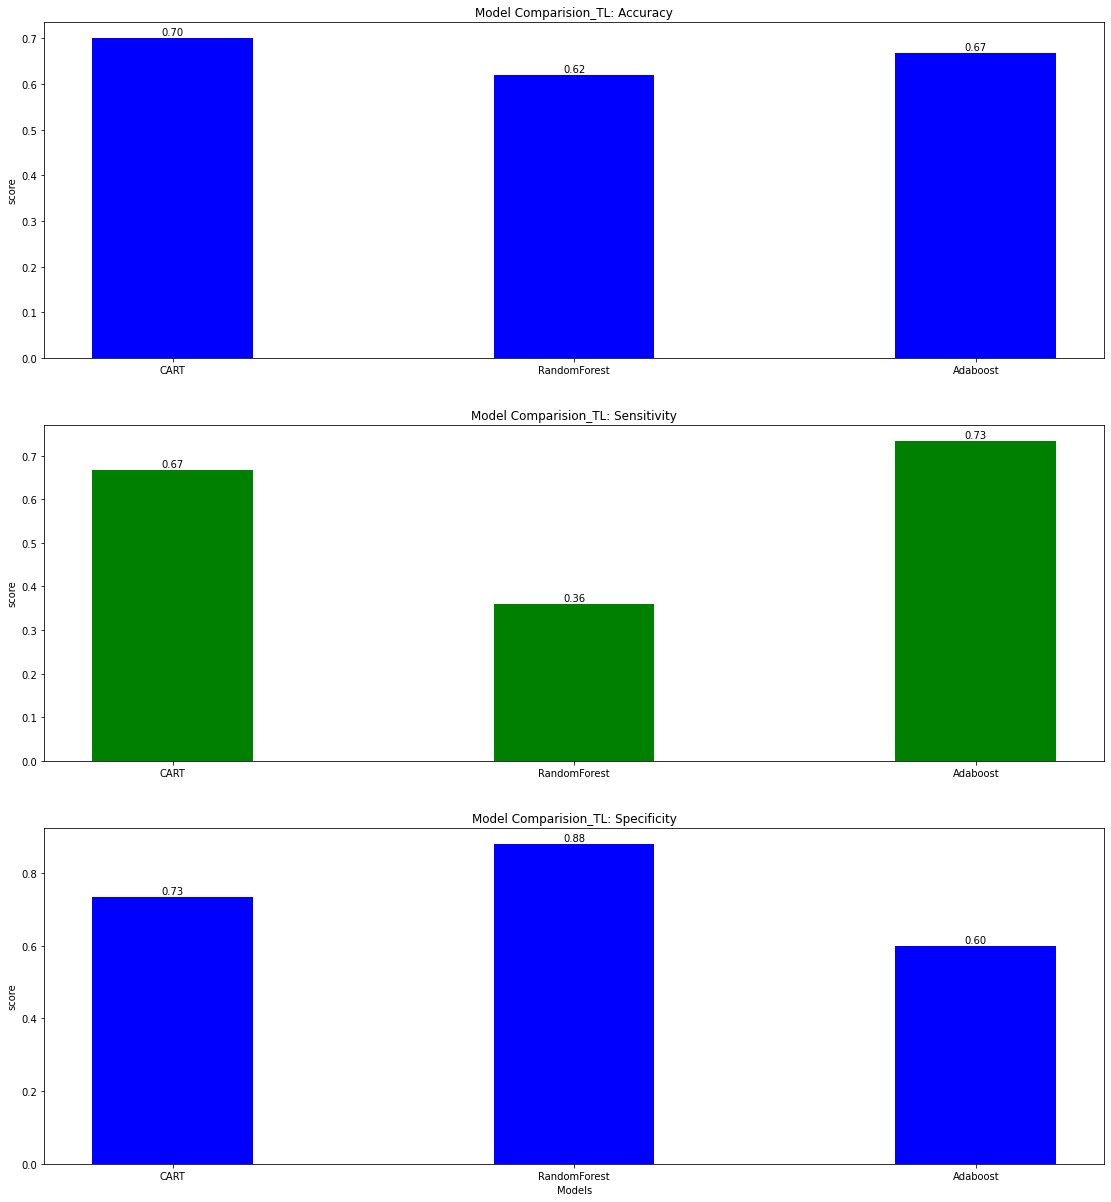

In [43]:
print("Case: Src-Wave|Tgt-Spiral, Kernel Density Estimation(kernel=Gaussian)")
experiment2_TL(Weights_KDE_2,"KDE")

### -X-X-X-X-X-X-X-X-X-